In [1]:
# TODO TO FIX

In [2]:
from functions import *

In [3]:
params = read_parameters()
subfolder = params['subfolder']
file_idx = params['file_idx']
tmp_idx = params['tmp_idx']
drop_initial_final_off_rows = params['drop_initial_final_off_rows']
drop_off_rows = params['drop_off_rows']
drop_outliers = params['drop_outliers']

subfolder: UF/
file_idx: 0
tmp_idx: 0
initial_feed_volume_L: 100
reset_columns_when_OFF: True
drop_initial_final_off_rows: True
drop_off_rows: True
drop_outliers: True
plot_scatterplot_matrix: False
use_default_arima_params: True
default_arima_params: [1, 1, 0]
include_arima_simulations_in_analysis: True


In [4]:
ext_folder = '../data/extended/' + subfolder 
in_folder  = ext_folder + 'v1/'
in_files = [ (in_folder, file) for file in os.listdir(in_folder) if re.match(".*\.csv", file) ]

cur_file = in_files[file_idx][1]
file_path = in_folder + cur_file

print("file list:")
for i in range(len(in_files)) :
    print(i, in_files[i][0] + in_files[i][1])
print(f"\ninput file:\n{file_path}")

file list:
0 ../data/extended/UF/v1/2023-11-08 0 clean water.csv
1 ../data/extended/UF/v1/2023-11-09 0 clean water.csv
2 ../data/extended/UF/v1/2023-11-09 1 dirty water.csv
3 ../data/extended/UF/v1/2023-11-09 2 dirty water.csv
4 ../data/extended/UF/v1/2023-11-09 3 dirty water.csv
5 ../data/extended/UF/v1/ALL_DATA.csv

input file:
../data/extended/UF/v1/2023-11-08 0 clean water.csv


In [5]:
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df['date'] = pd.to_datetime(df['datetime']).apply(lambda x : x.date())
df = df.reset_index()

In [6]:
df = drop_all_outliers(df, drop_initial_final_off_rows=drop_initial_final_off_rows, drop_off_rows=drop_off_rows, drop_outliers=drop_outliers, log=True)
df = df.reset_index(drop=True)
df['time [m]'] = change_col_offset(df, 'time [m]')

removed 3 initial rows
removed 4 final rows
 - dropped rows: 1
removing outliers rows of column: res tot [1/m]
 - dropped rows: 1
removing outliers rows of column: prs feed_2 [kPa]
 - dropped rows: 1
removing outliers rows of column: flux [L/m^2h]
 - dropped rows: 0
removing outliers rows of column: flux [L/m^2h]
 - dropped rows: 2


In [7]:
try:
    # already created
    df_k_n = pd.read_csv('integral_method.csv')
except:
    # to be created yet
    df_k_n = pd.DataFrame()

In [8]:
x_axis   = ('time [m]', 'datetime')
x_format = (None,       '%H:%M')
TIME_MINS = 0
DATE_TIME = 1
TIME_IDX  = TIME_MINS

(<Axes: xlabel='time [m]', ylabel='flux [LMH]'>,
 <Axes: title={'center': 'Flux and TMP over Time'}, ylabel='TMP [kPa]'>)

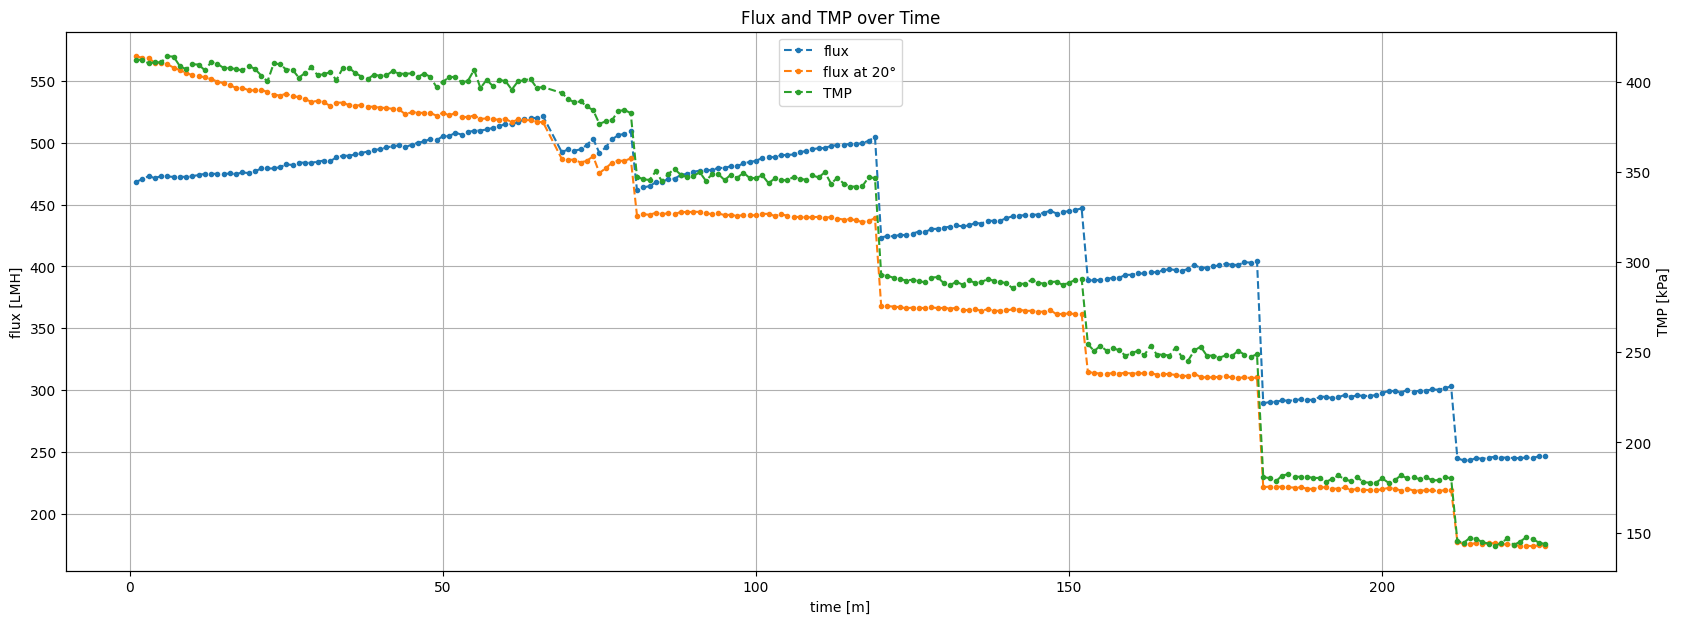

In [11]:
# STEP 1
# GOAL: 
# - find J_Re = flux asymptote (J_Re is a first estimate of J_R, the cross-flow removal term)
# - estimate initial flux J_0
# HOW: plot flux (J) vs filtration time (t)
y_dict = {
    'flux' : df['flux [L/m^2h]'],
    'flux at 20°' : df['flux at 20° [L/m^2h]'],
    'TMP'  : df['TMP [kPa]'],
}
y_ax_lbl = ['flux [LMH]', 'TMP [kPa]']
title    = 'Flux and TMP over Time'
#plot_time_series_1_axis(x=df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX])
plot_time_series_2_axis(x=df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX], secondary_y=['TMP'], loc='upper center')

In [12]:
TMP_intervals = TMP_INTERVALS[cur_file]
TMP_intervals

{0: (None, 68),
 1: (68, 81),
 2: (81, 120),
 3: (120, 153),
 4: (153, 181),
 5: (181, 212),
 6: (212, None)}

In [13]:
(l, r) = TMP_intervals[tmp_idx] #.get(tmp_idx, (None, None))
if l is not None :
    df = df[(df['time [m]'] >= l)]
if r is not None : 
    df = df[(df['time [m]'] < r)]
df = df.reset_index(drop=True)
df['time [m]'] = change_col_offset(df, 'time [m]')
# USE_ARIMA_FORECAST = (len(df) > 4)

In [ ]:
# STEP 1
# GOAL: 
# - find J_Re = flux asymptote (J_Re is a first estimate of J_R, the cross-flow removal term)
# - estimate initial flux J_0
# HOW: plot flux (J) vs filtration time (t)

df['res tot [%]'] = min_max_scaler(df['res tot [1/m]'])
df['TMP [%]'] = min_max_scaler(df['TMP [kPa]'])
df['viscosity permeate [%]'] = min_max_scaler(df['viscosity permeate [Pa s]'])
y_dict = {
    'flux' : df['flux [L/m^2h]'],
    'res'  : df['res tot [%]'],
    'TMP'  : df['TMP [%]'],
    'viscosity' : df['viscosity permeate [%]'],
}
print(df.agg({
    'flux [L/m^2h]' : ["min", "median", "mean",  "max", "std", "var"],
    "res tot [1/m]" : ["min", "median", "mean",  "max", "std", "var"],
    "TMP [kPa]"     : ["min", "median", "mean",  "max", "std", "var"],
    "viscosity permeate [Pa s]"     : ["min", "median", "mean",  "max", "std", "var"],
}))

y_ax_lbl = ['flux [LMH]', 'resistance [1/m]']
title    = 'Flux and resistance over Time'
#plot_time_series_1_axis(x=df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX])
plot_time_series_2_axis(x=df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX], secondary_y=['res', 'TMP', 'viscosity'], loc='upper center')

In [ ]:
df_train = df['flux [L/m^2h]']
lags = math.floor(len(df) / 2) - 1
print("lags:", lags)
adf_test, is_significant = check_stationarity(df_train, lags=lags)

In [ ]:
is_significant = False
if is_significant :
    differencing = False
    print("NOT differencing")
else :
    differencing = True
    print("differencing")
    df_train_diff = df_train.diff().dropna()
    adf_test, is_significant = check_stationarity(df_train, lags=lags)    

In [ ]:
d = 1 if differencing else 0
print(f"d: {d}")
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False, trace=True, information_criterion='hqic', d=d)
(p,d,q) = auto_arima.get_params()['order']

In [ ]:
# specify p, d, q
model = arima.ARIMA(df_train, order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

In [ ]:
forecast = model_fit.forecast(1000)
print(forecast[-5:])

In [ ]:
# use only first 3 values to find J_0
df0 = df[[x_axis[TIME_IDX], 'flux [L/m^2h]']][:3]
display(df0)
model00, y_pred00, intercept00, coeffs00 = call_linear_model(df0[[x_axis[TIME_IDX]]], df0['flux [L/m^2h]'], summary=False)

In [ ]:
### FOUND PARAMETERS !!!!!!!!!!!!
J_0  = intercept00
J_Re = list(forecast)[-1]
print(f"J_0  = {J_0:>.5f}")
print(f"J_Re = {J_Re:>.5f}")

In [ ]:
n_periods=50
x_forecast = range(len(df)+1,n_periods+len(df)+1)
y_forecast = forecast[:n_periods]
plot_time_series_1_axis(x=[0], y_series={"flux in t=0" : [J_0]}, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=None, title=None, x_format=x_format[TIME_IDX], color="green")
plot_time_series_1_axis(x=df[x_axis[TIME_IDX]], y_series={'flux real' : df['flux [L/m^2h]']}, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=None, title=None, x_format=x_format[TIME_IDX], figsize=None)
plot_time_series_1_axis(x=x_forecast, y_series={'flux forecast': y_forecast}, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl='flux [L/m^2h]', title='Flux forecast', x_format=x_format[TIME_IDX], color='red', figsize=None)
plot.axhline(J_Re, label='flux asymptote', color='black')
plot.legend()
plot.show()

In [ ]:
#####################################################
# since we have few data points we use the forecast as dataset itself
if True:
    df_bckup = df
    df['is forecast'] = False
    df = df[['time [m]', 'flux [L/m^2h]', 'area tot [m^2]', 'flow permeate [L/h]', 'is forecast']]
    df_forecast = pd.DataFrame()
    df_forecast['time [m]'] = [ t for t in x_forecast]
    df_forecast['flux [L/m^2h]'] = y_forecast.reset_index(drop=True)
    #df_start = pd.DataFrame()
    #df_start['time [m]'] = [ 0 ]
    #df_start['flux [L/m^2h]'] = [ J_0 ]
    for df_concat in [df_forecast] : # [df_start, df_forecast] :
        df_concat['is forecast'] = True
        df_concat['area tot [m^2]'] = df.loc[0, 'area tot [m^2]']
        df_concat['flow permeate [L/h]'] = df_concat['flux [L/m^2h]'] * df_concat['area tot [m^2]']
    df = pd.concat([df, df_forecast]).reset_index(drop=True)
    #df = pd.concat([df_start, df, df_forecast]).reset_index(drop=True)

In [ ]:
df['d/dt flux'] = df['flux [L/m^2h]'].diff() #.fillna(0)
df['J - J_Re'] = df['flux [L/m^2h]'] - J_Re
df['k(n=2)'] = df.apply(lambda x : 0 if x['J - J_Re'] < 0.000001 else - x['d/dt flux'] / x['J - J_Re'], axis = 1)

In [ ]:
print(J_Re)
display(df[['flux [L/m^2h]', 'd/dt flux', 'J - J_Re', 'k(n=2)', 'is forecast']].tail(15))

In [ ]:
df_real  = df[df['is forecast'] == False]
df_frcst = df[df['is forecast'] == True]
plot_time_series_1_axis(x=df_real[x_axis[TIME_IDX]],  y_series={'k(n=2) real' :    df_real['k(n=2)']}, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=None, title=None, x_format=x_format[TIME_IDX])
plot_time_series_1_axis(x=df_frcst[x_axis[TIME_IDX]], y_series={'k(n=2) forecast': df_frcst['k(n=2)']}, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl='k(n=2)', title='k(n=2) = - flux\' / (flux - flux_min)', x_format=x_format[TIME_IDX], color='red', figsize=None)
plot.legend()
plot.grid()
plot.show()

In [ ]:
k_min = {
    2 : list(df['k(n=2)'])[-1] 
}
df_real  = df[df['is forecast'] == False].dropna()
df_frcst = df[df['is forecast'] == True].dropna()
model, y_pred, intercept, coeffs = call_linear_model(df_real[['time [m]']], df_real['k(n=2)'], summary=True)
df['k(n=2) pred'] =  df['time [m]'].apply(lambda x : max(k_min[2], intercept + coeffs[0] * x))
plot_time_series_1_axis(x=df_real[x_axis[0]],  y_series={'k(n=2) arima real'  : df_real['k(n=2)']},  x_ax_lbl=x_axis[0], y_ax_lbl='k(n=2)', title=None, x_format=x_format[0], color=['green'], s=4)
plot_time_series_1_axis(x=df_frcst[x_axis[0]], y_series={'k(n=2) arima frcst' : df_frcst['k(n=2)']}, x_ax_lbl=x_axis[0], y_ax_lbl='k(n=2)', title=None, x_format=x_format[0], color=['gold'],  s=4, figsize=None)
plot_time_series_1_axis(x=df[x_axis[0]], y_series={'k(n=2) pred' : df['k(n=2) pred']}, x_ax_lbl=x_axis[0], y_ax_lbl='k(n=2)', title=None, x_format=x_format[0], color=['lightcoral'], s=4, figsize=None)
plot.legend()

In [ ]:
print(f"k(n=2) = max({k_min[2]}, {intercept} + {coeffs[0]} * time [m])")
col = df['k(n=2)'].values
print(df.agg({'k(n=2) pred' : ["min", "median", "mean",  "max"] }))

In [ ]:
init_cond = df_bckup.loc[0]
print(init_cond)

In [ ]:
# df_k_n = pd.DataFrame()

In [ ]:
df_k_n_current = {
    'date'                : DATE,
    'file_idx'            : file_idx,
    'tmp_idx'             : tmp_idx,
    'n'                   : 2,
    'intercept'           : intercept,
    'coeff time [m]'      : coeffs[0],
    'initial TMP [kPa]'   : init_cond['TMP [kPa]'],
    'initial res [1/m]'   : init_cond['res tot [1/m]'],
    'initial visc [Pa s]' : init_cond['viscosity permeate [Pa s]'],
    'initial flux [L/m^2h]' : init_cond['flux [L/m^2h]'],
}
# remove current row if is present
if not df_k_n.empty :
    df_k_n = df_k_n[ ((df_k_n['date'] != DATE) | (df_k_n['file_idx'] != file_idx) | (df_k_n['tmp_idx'] != tmp_idx)) ]
# add the current row to the df
df_k_n = pd.concat([df_k_n, pd.DataFrame([df_k_n_current])], ignore_index=True).reset_index(drop=True)
df_k_n.to_csv(PATH_DATA_EST_FLUX_SLOPESLOPE, index=False)
df_k_n

In [ ]:
def fn(J, n, J_0) :
    if n == 0 : 
        return J.map(lambda j : (1 / j - 1 / J_0))
    if n == 1 :
        return J.map(lambda j : math.log(J_0 / j))
    if n == 1.5 :
        return J.map(lambda j : (math.sqrt(J_0) - math.sqrt(j)))
    if n == 2 :
        return J.map(lambda j : (J_0 - j))

In [ ]:
# recompute volume permeate
df.loc[0, 'delta vol permeate [L]'] = J_0 * df.loc[0, 'area tot [m^2]'] / 60
df.loc[0, 'vol permeate [L]'] = df.loc[0, 'delta vol permeate [L]']
for i in range(1, len(df)):
    df.loc[i, 'delta vol permeate [L]'] = (df.loc[i-1, 'flow permeate [L/h]'] / 60)
    df.loc[i, 'vol permeate [L]'] = df.loc[i-1, 'vol permeate [L]'] + df.loc[i, 'delta vol permeate [L]']

In [ ]:
# STEP 2
# GOAL: plot fn(J, n) vs (v − J_Re * t), with n = {0, 1, 1.5, 2}
# HOW:  generate time series (v − J_Re * t)
# Specific volume: v = VOL_PERMEATE ∕ AREA
df['v [L/m^2]'] = df['vol permeate [L]'] / df['area tot [m^2]']
# Real Flow * t - Minimum Flow * t = Real Volume Permeate - Minimum Volume Permeate
df['v - J_Re*t [L/m^2]'] = (df['v [L/m^2]'] - (J_Re/60 * df['time [m]']))

In [ ]:
df.head(5)

In [ ]:
# STEP 3
# GOAL: check if any n fits the data otherwise find the inflection point
# HOW: plot fn(J, n) vs (v − J_Re * t), with n = {0, 1, 1.5, 2}
y_dict = {}
for n in [0, 1, 1.5, 2] :
    lbl = f'n={n}'
    col_name = f'f(J, n={n})'
    df[col_name] = fn(df['flux [L/m^2h]'], n, J_0)
    y_dict[lbl] = df[col_name]

In [ ]:
print(J_0, J_Re)
df[['time [m]', 'flux [L/m^2h]', 'flow permeate [L/h]',
       'vol permeate [L]', 'delta vol permeate [L]', 'v [L/m^2]',
       'v - J_Re*t [L/m^2]', 'f(J, n=0)', 'f(J, n=1)', 'f(J, n=1.5)', 'f(J, n=2)']].head(10)

In [ ]:
# TODO TO BE SET MANUALLY CHECKING THE CHART BELOW
inflection_point = 3

In [ ]:
rows = 1
cols = 4
fig, axs = plot.subplots(rows, cols, figsize=(7*cols, 5*rows))
i = 0
j = 0
for (lbl, col) in y_dict.items() :
    y_dict_tmp = {}
    y_dict_tmp[lbl] = col
    #model, y_pred, intercept, coeffs = call_linear_model(df[['v - J_Re*t [L/m^2]']], col, summary=True)
    #y_dict_tmp[lbl + ' lm'] = y_pred
    idx = j if rows == 1 else (i, j)
    plot_time_series_1_axis(x=df['v - J_Re*t [L/m^2]'], y_series=y_dict_tmp, x_ax_lbl='v - J_Re * t', y_ax_lbl='f(J, n)', title=lbl, x_format=x_format[TIME_IDX], cur_ax=axs[idx])
    axs[idx].axvline(df.loc[inflection_point, 'v - J_Re*t [L/m^2]'], label='inflection point', color='black')
    
    j = (j + 1) % cols
    if j == 0 :
        i += 1
    axs[idx].legend()
plot.suptitle('f(J, n) vs (v - J_Re * t)')
plot.show()

In [ ]:
# STEP 4.0
df['v / t [L/m^2*min]'] = df['v [L/m^2]'] / df['time [m]']
y_dict = {}
for n in [0, 1, 1.5, 2] :
    lbl = f'n={n}'
    col_name = f'f(J, n={n}) / t'
    df[col_name] = df[f'f(J, n={n})'] / df['time [m]']
    y_dict[lbl] = df[col_name]

In [ ]:
def get__y_dict(df, f_col_name) :
    y_dict = {}
    for n in [0, 1, 1.5, 2] :
        col_name = f_col_name(n)
        y_dict[f'n={n}'] = df[col_name]
    return y_dict

In [ ]:
# STEP 4
# GOAL: estimate n for data points 0 <= t <= inflection for the first phase of fouling
# HOW:  
# - plot (fn(J, n) / t) vs (v / t)
# - foreach couple(J,n) find (m,q) the best linear approximation
# n: y = m*x + q, where x = (v/t)
cur_df = df[:inflection_point+1]
f_col_name = (lambda x : 'f(J, n=' + str(x) + ') / t')
y_dict = get__y_dict(cur_df, f_col_name)
########## TODO
n1 = 2


In [ ]:
rows = 1
cols = 4
fig, axs = plot.subplots(rows, cols, figsize=(7*cols, 5*rows))
i = 0
j = 0
for (lbl, col) in y_dict.items() :
    y_dict_tmp = {}
    y_dict_tmp[lbl] = col
    idx = j if rows == 1 else (i, j)
    plot_time_series_1_axis(x=cur_df['v / t [L/m^2*min]'], y_series=y_dict_tmp, x_ax_lbl='v / t [L/m^2*min]', y_ax_lbl='f(J, n) / t', title=lbl, x_format=x_format[TIME_IDX], cur_ax=axs[idx], color=[COLOR_CYCLE[i*cols+j]])
    j = (j + 1) % cols
    if j == 0 :
        i += 1
plot.suptitle('f(J, n)/t vs v/t')
plot.show()

In [ ]:
# STEP 5
# GOAL: estimate n for data points inflection <= t <= +inf for the second phase of fouling
# HOW:
# - plot (fn(J, n) / t) vs (v / t)
# - foreach couple(J,n) find (m,q) the best linear approximation: y = m*x + q, where x = (v/t)
cur_df = df[inflection_point:]
f_col_name = (lambda x : 'f(J, n=' + str(x) + ') / t')
y_dict = get__y_dict(cur_df, f_col_name)
rows = 1
cols = 4
fig, axs = plot.subplots(rows, cols, figsize=(7*cols, 5*rows))
i = 0
j = 0
for (lbl, col) in y_dict.items() :
    y_dict_tmp = {}
    y_dict_tmp[lbl] = col
    idx = j if rows == 1 else (i, j)
    plot_time_series_1_axis(x=cur_df['v / t [L/m^2*min]'], y_series=y_dict_tmp, x_ax_lbl='v / t [L/m^2*min]', y_ax_lbl='f(J, n) / t', title=lbl, x_format=x_format[TIME_IDX], cur_ax=axs[idx], color=[COLOR_CYCLE[i*cols+j]])
    j = (j + 1) % cols
    if j == 0 :
        i += 1
plot.suptitle('f(J, n)/t vs v/t')
plot.show()
########## TODO
n2 = 1

In [ ]:
# f(n) / t = K_n v / t − K_n * J_R ==> # f(n) = t * (K_n v / t − K_n * J_R) = K_n * (v - J_R * t)

def rhs(v, t, K_n, J_R) :
    return K_n * (v - J_R * t)

def estimate_flux(n, v, t, K_n, J_R, J_0) :
    val =  rhs(v, t, K_n, J_R)
    if n == 0 : 
        return 1 / (val + (1 / J_0))
    if n == 1 :
        return math.exp(math.log(J_0) - val)
    if n == 1.5 :
        # J_R is expected to be 0
        return (val - J_0) ** 2
    if n == 2 :
        return J_0 - val

In [ ]:
# STEP 6
# GOAL: optimise the estimated parameter values in order to obtain the expressions for flux as a function of time
# HOW: TODO
# CHECK ESTIMATIONS VS REAL FLUX
df['estimated flux [L/m^2h]'] = estimate_flux(n, v, t, K_n, J_R, J_0)
plot_time_series(x=cur_df['v / t'], y_series=y_dict, x_lbl='(v / t)', y_lbl='f(J, n) / t', title='(f(J, n) / t) vs (v / t)')